# PCA practical session
# Nov 6, 2019
# Kazuyoshi Ishigaki
- PCA analysis using 1000G data
- to save time, only genotype data of Chr 1 were used
- Pruned (r2<0.1)
- Stratified genotype data by MAF

In [19]:
# packages
library(magrittr) 
library(data.table)
library(ggsci)
library(ggplot2)
library(irlba)

In [23]:
options(repr.plot.width=5, repr.plot.height=4)

## Summary slide

<img src="./image6.png">

## I, PCA using common variants (MAF>0.05)

### I-1 PCA plot by plink (as a reference data)
- introduction of ggsci (a very cool package!)

In [24]:
#plink pca results
plink_pca <- fread("pruned.common.10000.snps.eigenvec",
                   colClasses=c(rep("character",2), rep("numeric",20)))
plink_pca <- as.data.frame(plink_pca[,c(1,3,4),with=F])
colnames(plink_pca) <- c("ID","PC1","PC2")
    #head(plink_pca)

popinfo <- read.table("pop.info", header=F)
colnames(popinfo) <- c("ID","pop")

df <- merge(plink_pca, popinfo, by="ID")
df$pop <- factor(df$pop, levels=c("AFR", "AMR", "EAS", "EUR", "SAS"))

In [25]:
head(df) #df is a data.frame which has PCA results by plink
table(df$pop)

ID,PC1,PC2,pop
HG00096,-0.01275320,0.0249022,EUR
HG00097,-0.00976217,0.0255714,EUR
HG00099,-0.01038320,0.0290929,EUR
HG00100,-0.01050970,0.0264893,EUR
HG00101,-0.01167050,0.0288440,EUR
HG00102,-0.01094880,0.0257775,EUR



AFR AMR EAS EUR SAS 
661 347 504 503 489 

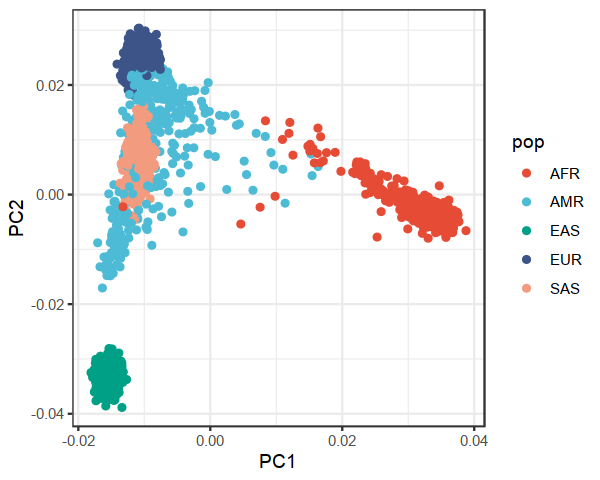

In [26]:
#plot with NPG-themed colors
df %>% ggplot(aes(x=PC1, y=PC2, color=pop)) +
  geom_point() +
  theme_bw() +
  scale_color_npg()

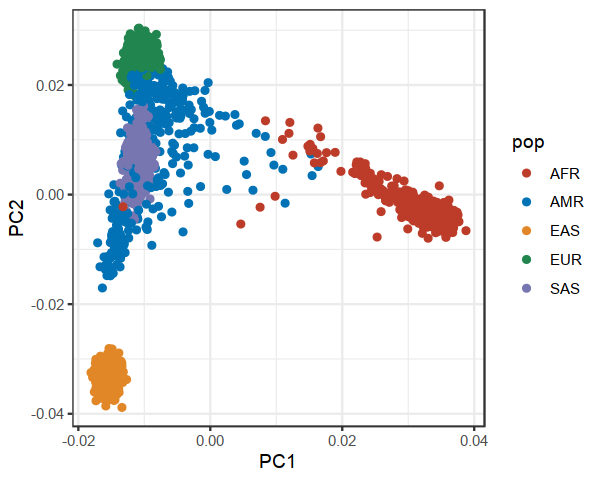

In [27]:
#plot with NEJM-themed colors
df %>% ggplot(aes(x=PC1, y=PC2, color=pop)) +
  geom_point() +
  theme_bw() +
  scale_color_nejm()

### I-2, PCA with prcomp

In [5]:
#read raw genotype data
d1 <- fread("1000g_chr1_pruned_common.dosage.gz", header=T, stringsAsFactors = F,
            colClasses=c("character",rep("numeric",2504)))
d1 <- as.data.frame(d1)
colnames(d1) <- sapply(colnames(d1), function(x){unlist(strsplit(x,"_"))[1]})
geno <- as.matrix(d1[,2:ncol(d1)])
row.names(geno) <- as.character(d1[,1])

popinfo <- read.table("pop.info", header=F)
colnames(popinfo) <- c("ID","pop")

In [6]:
geno[1:4,1:4]
dim(geno)

,HG00096,HG00097,HG00099,HG00100
1_13273_G_C,0,0,0,0
1_14930_A_G,1,1,1,1
1_15903_G_GC,1,1,0,1
1_51479_T_A,2,0,0,0


[1] 9713 2504

In [11]:
#centering 
geno_c <- t(apply(geno, 1, function(x){
    Mean <- mean(x);
    center <- x - Mean;
    return(center)
}))

In [12]:
geno_c[1:4,1:4]
dim(geno_c)

,HG00096,HG00097,HG00099,HG00100
1_13273_G_C,-0.19009585,-0.19009585,-0.19009585,-0.19009585
1_14930_A_G,0.03554313,0.03554313,0.03554313,0.03554313
1_15903_G_GC,0.11781150,0.11781150,-0.88218850,0.11781150
1_51479_T_A,1.74361022,-0.25638978,-0.25638978,-0.25638978


[1] 9713 2504

In [13]:
#centering and scaling
geno_cs <- t(apply(geno, 1, function(x){
    Mean <- mean(x);
    SD <- sd(x);
    scaled <- ( x - Mean ) / SD;
    return(scaled)
}))

In [14]:
geno_cs[1:4,1:4]
dim(geno_cs)

,HG00096,HG00097,HG00099,HG00100
1_13273_G_C,-0.4654439,-0.4654439,-0.4654439,-0.4654439
1_14930_A_G,0.1020155,0.1020155,0.1020155,0.1020155
1_15903_G_GC,0.1530940,0.1530940,-1.1463883,0.1530940
1_51479_T_A,3.0969511,-0.4553923,-0.4553923,-0.4553923


[1] 9713 2504

In [150]:
#prcomp using genotype data with centering and scaling
#input data (geno_cs) is already centered and scaled. So, I disabled scaling and centering in prcomp function.
#takes a few mininutes. stored results.
#system.time( pca <- prcomp(t(geno_cs), scale = FALSE, center = FALSE) )
#    user   system  elapsed 
#2887.706   38.884  132.459

    user   system  elapsed 
2887.706   38.884  132.459 

In [151]:
#save(pca, file= "prcomp_1kg_chr1_common.RData" )

In [2]:
load("prcomp_1kg_chr1_common.RData")

In [197]:
#structure of outputs in prcomp
str(pca)

List of 5
 $ sdev    : num [1:2504] 26.3 17.2 9.48 8.21 4.58 ...
 $ rotation: num [1:9713, 1:2504] -0.007764 0.000805 -0.0252 -0.008086 0.005532 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:9713] "1_13273_G_C" "1_14930_A_G" "1_15903_G_GC" "1_51479_T_A" ...
  .. ..$ : chr [1:2504] "PC1" "PC2" "PC3" "PC4" ...
 $ center  : logi FALSE
 $ scale   : logi FALSE
 $ x       : num [1:2504, 1:2504] -16.6 -13 -13.3 -13.7 -15.3 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:2504] "HG00096" "HG00097" "HG00099" "HG00100" ...
  .. ..$ : chr [1:2504] "PC1" "PC2" "PC3" "PC4" ...
 - attr(*, "class")= chr "prcomp"


In [21]:
#PC scores (length of samples)
Z <- pca$x
Z[1:4,1:4]

,PC1,PC2,PC3,PC4
HG00096,-16.62853,21.22611,6.717405,-4.473550
HG00097,-12.97861,21.86870,7.246462,-4.816835
HG00099,-13.29884,25.21054,6.413888,-5.642631
HG00100,-13.65039,23.09492,6.577044,-6.298016


In [199]:
#eigen vectors (length of SNPs)
W <- pca$rotation
W[1:4,1:4]

,PC1,PC2,PC3,PC4
1_13273_G_C,-0.0077637542,0.009633678,-0.0016317206,0.0091557817
1_14930_A_G,0.0008047414,0.011774275,0.0032395254,0.0105673905
1_15903_G_GC,-0.0251998735,-0.018562226,-0.0005051175,-0.0118459474
1_51479_T_A,-0.0080859457,0.019208150,-0.0175128183,-0.0008266066


In [7]:
#eigen values
#IMPORTANT NOTE: prcomp calculate eigenvalues of covariance matrix
#we need to multiply by (n-1) to get eigenvalue of original matrix
eigs.covmat <- pca$sdev^2
eigs <- ( ncol(geno)  - 1 ) * eigs.covmat

#variance explained by PC1
eigs[1] / sum(eigs)

[1] 0.07119106

In [9]:
#summary
#summary(pca)

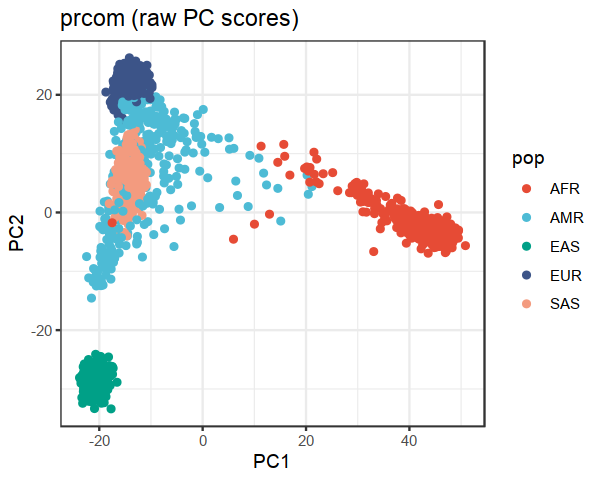

In [28]:
#raw Z values
#almost same as pling pca, but absolute value is different.
#need to be scaled by eigenvalues
toppc <- Z[,1:2]
df <- data.frame(ID=row.names(toppc), toppc)
df <- merge(df, popinfo, by="ID")

df %>% ggplot(aes(x=PC1, y=PC2, color=pop)) +
    geom_point() +
    theme_bw() +
    scale_color_npg() +
    labs(title="prcom (raw PC scores)")

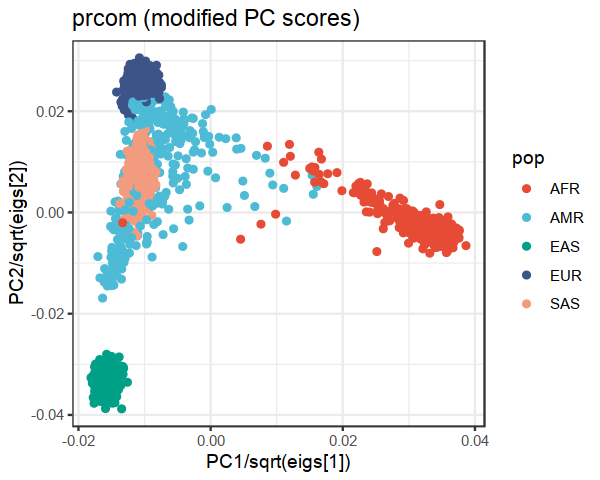

In [31]:
#adjusting Z values using eigenvalues 
#scaled with square root of eigen values

toppc <- Z[,1:2]
df <- data.frame(ID=row.names(toppc), toppc)
df <- merge(df, popinfo, by="ID")

df %>% ggplot(aes(x=PC1/sqrt(eigs[1]), y=PC2/sqrt(eigs[2]), color=pop)) +
    geom_point() +
    theme_bw() +
    scale_color_npg() +
    labs(title="prcom (modified PC scores)")

In [162]:
# Can we calculate Z from X and W?
# Yes!
X <- geno_cs
Zest <- t(W) %*% X

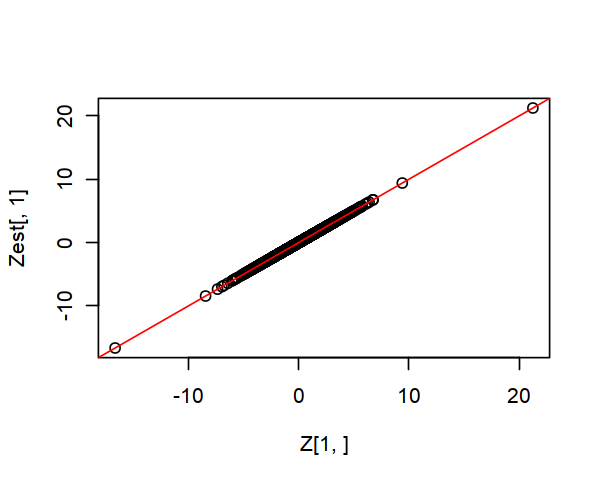

In [163]:
plot( Z[1,], Zest[,1])
abline(a=0, b=1, col="red")

### I-3, PCA with irlba (genotype data with centering and scaling)

In [15]:
#use irlba (implemented in Seurat)
#computing efficiency is dependent on the number of PCs calculated.
pcs.compute <- 2
set.seed(seed = 1)

system.time( pca.results <- irlba(A = t(geno_cs), nv = pcs.compute ) )

   user  system elapsed 
 10.709   0.078   0.767 

In [212]:
pcs.compute <- 5
set.seed(seed = 1)

system.time( pca.results <- irlba(A = t(geno_cs), nv = pcs.compute ) )

   user  system elapsed 
 15.284   0.036   0.840 

In [32]:
pcs.compute <- 10
set.seed(seed = 1)

system.time( pca.results <- irlba(A = t(geno_cs), nv = pcs.compute ) )

   user  system elapsed 
 34.072   0.141   1.718 

In [214]:
str(pca.results)

List of 5
 $ d    : num [1:10] 1316 860 474 411 229 ...
 $ u    : num [1:2504, 1:10] 0.01264 0.00987 0.01011 0.01038 0.01159 ...
 $ v    : num [1:9713, 1:10] 0.007764 -0.000805 0.0252 0.008086 -0.005532 ...
 $ iter : int 10
 $ mprod: int 96


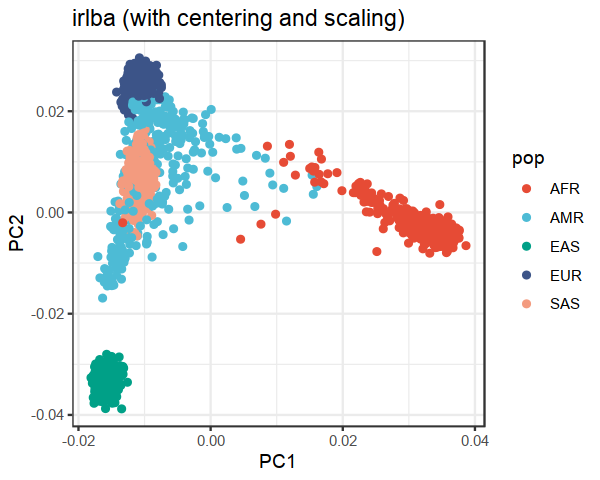

In [217]:
#use the raw scores in U
#OK! Almost same as pca plot using plink
U <- pca.results$u
toppc <- U[,1:2]
toppc <- - toppc

colnames(toppc) <- c("PC1","PC2")
df <- data.frame(ID=colnames(geno), toppc)
df <- merge(df, popinfo, by="ID")

df %>% ggplot(aes(x=PC1, y=PC2, color=pop)) +
    geom_point() +
    theme_bw() +
    scale_color_npg() +
    labs(title="irlba (with centering and scaling)")

df_geno_cs <- df #save for later analysis

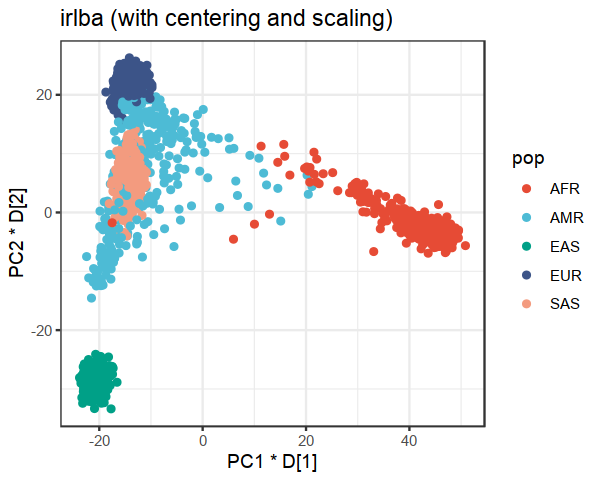

In [33]:
#consider the variance 
U <- pca.results$u
toppc <- U[,1:2]
toppc <- - toppc

D <- pca.results$d

colnames(toppc) <- c("PC1","PC2")
df <- data.frame(ID=colnames(geno), toppc)
df <- merge(df, popinfo, by="ID")

df %>% ggplot(aes(x= PC1*D[1] , y= PC2*D[2] , color=pop)) +
    geom_point() +
    theme_bw() +
    scale_color_npg() +
    labs(title="irlba (with centering and scaling)")


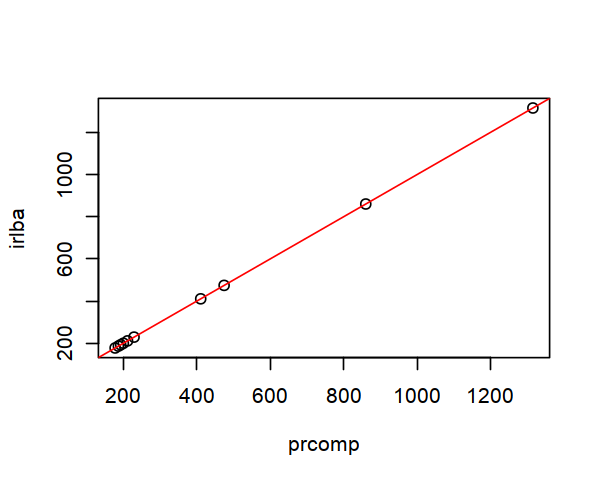

In [35]:
#Chech the consistency of eigen value estimation: prcomp (eigs) vs irlba (D)
#OK. They are consistent!
plot(sqrt(eigs[1:10]), D[1:10], xlab="prcomp", ylab="irlba" )  #eigs[1:10], D[1:10]
abline(a=0,b=1,col="red")

### I-4, PCA with irlba (without scaling and centering)
- centering substantially affects PCA results!

In [171]:
pcs.compute <- 2
set.seed(seed = 1)
weight.by.var = TRUE

system.time( pca.results <- irlba(A = t(geno), nv = pcs.compute ) )

   user  system elapsed 
 11.063   0.010   0.894 

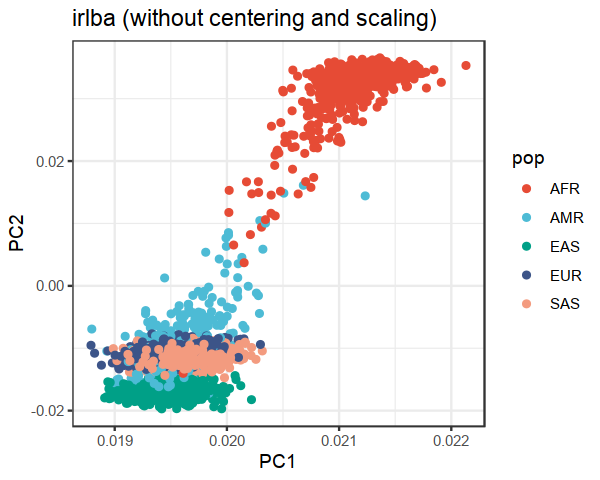

In [172]:
#use the raw scores in U
U <- pca.results$u
toppc <- U[,1:2]
toppc <- - toppc

colnames(toppc) <- c("PC1","PC2")
df <- data.frame(ID=colnames(geno), toppc)
df <- merge(df, popinfo, by="ID")

df %>% ggplot(aes(x=  PC1, y=  PC2, color=pop)) +
    geom_point() +
    theme_bw() +
    scale_color_npg() +
    labs(title="irlba (without centering and scaling)")
    #comment: obviously, substantial change in PC scores happened.

### II-5, PCA with irlba (only centering: without scaling)
- the effect of scaling is small in PCA using common variants

In [173]:
pcs.compute <- 2
set.seed(seed = 1)
weight.by.var = TRUE

system.time( pca.results <- irlba(A = t(geno_c), nv = pcs.compute ) )

   user  system elapsed 
 10.689   0.014   0.691 

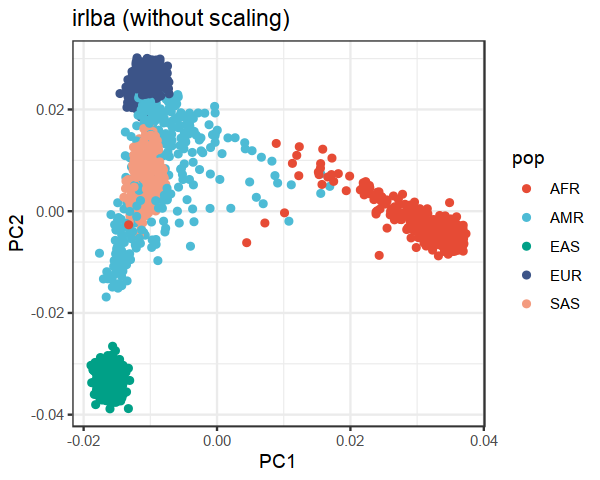

In [174]:
#use the raw scores in U
#almost same plot as PCA using genotype with centering and scaling
U <- pca.results$u
toppc <- U[,1:2]
toppc[,1] <- - toppc[,1] #adjust direction
toppc[,2] <- - toppc[,2] #adjust direction

colnames(toppc) <- c("PC1","PC2")
df <- data.frame(ID=colnames(geno), toppc)
df <- merge(df, popinfo, by="ID")

df %>% ggplot(aes(x=  PC1, y=  PC2, color=pop)) +
    geom_point() +
    theme_bw() +
    scale_color_npg() +
    labs(title="irlba (without scaling)")

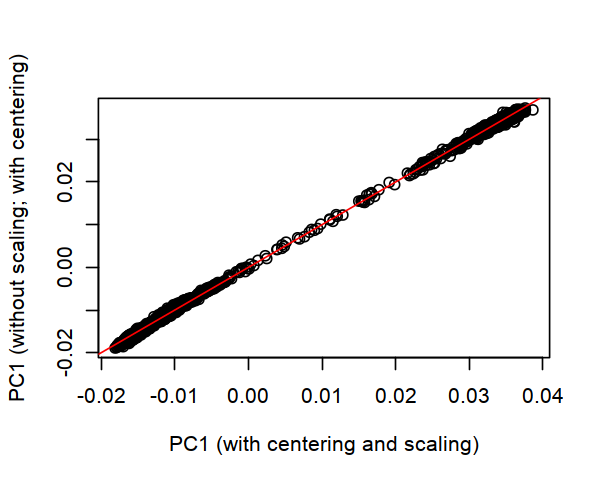

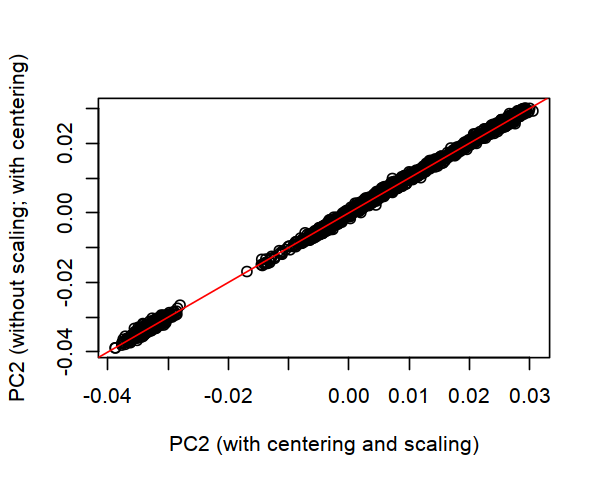

In [175]:
#because change was very subtle, I compared PC1,2 scores directly.
#slightly different
plot(df_geno_cs$PC1, df$PC1, xlab="PC1 (with centering and scaling)", ylab="PC1 (without scaling; with centering)")
abline(a=0,b=1,col="red")

plot(df_geno_cs$PC2, df$PC2, xlab="PC2 (with centering and scaling)", ylab="PC2 (without scaling; with centering)")
abline(a=0,b=1,col="red")

## II, PCA using low-frequency variants (MAF < 0.05)

In [176]:
#read raw genotype data
d1 <- fread("1000g_chr1_pruned_lowfreq.dosage.gz", header=T, stringsAsFactors = F,
            colClasses=c("character",rep("numeric",2504)))
d1 <- as.data.frame(d1)
colnames(d1) <- sapply(colnames(d1), function(x){unlist(strsplit(x,"_"))[1]})
geno <- as.matrix(d1[,2:ncol(d1)])
row.names(geno) <- as.character(d1[,1])

popinfo <- read.table("pop.info", header=F)
colnames(popinfo) <- c("ID","pop")

In [177]:
geno[1:4,1:4]
dim(geno)

,HG00096,HG00097,HG00099,HG00100
1_116117_CTTA_C,0,0,0,0
1_139046_G_A,0,0,0,0
1_625146_A_C,0,0,0,0
1_719873_G_T,0,0,0,0


[1] 9972 2504

In [178]:
#centering 
geno_c <- t(apply(geno, 1, function(x){
    Mean <- mean(x);
    center <- x - Mean;
    return(center)
}))

In [179]:
#centering and scaling
geno_cs <- t(apply(geno, 1, function(x){
    Mean <- mean(x);
    SD <- sd(x);
    scaled <- ( x - Mean ) / SD;
    return(scaled)
}))

### II-3, PCA with irlba (genotype data with centering and scaling)

In [180]:
#use irlba (implemented in Seurat)
#computing efficiency is dependent on the number of PCs calculated.
pcs.compute <- 2
set.seed(seed = 1)

system.time( pca.results <- irlba(A = t(geno_cs), nv = pcs.compute ) )

   user  system elapsed 
 14.923   0.039   0.759 

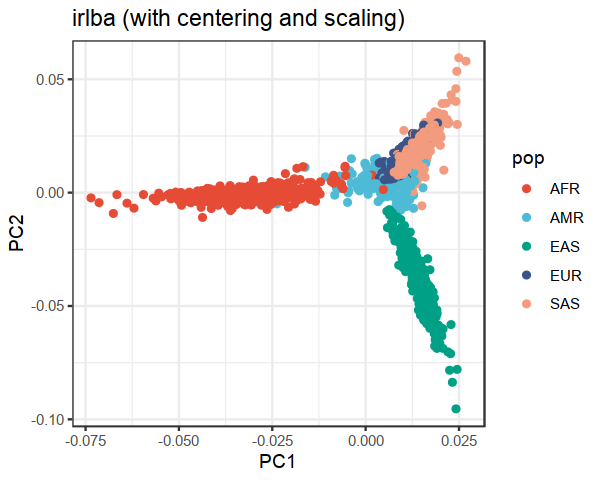

In [181]:
#use the raw scores in U
#OK! Almost same as pca plot using plink
U <- pca.results$u
toppc <- U[,1:2]
toppc <- - toppc

colnames(toppc) <- c("PC1","PC2")
df <- data.frame(ID=colnames(geno), toppc)
df <- merge(df, popinfo, by="ID")

df %>% ggplot(aes(x=PC1, y=PC2, color=pop)) +
    geom_point() +
    theme_bw() +
    scale_color_npg() +
    labs(title="irlba (with centering and scaling)")

df_geno_cs <- df #save for later analysis

### II-4, PCA with irlba (without scaling and centering)
- centering substantially affects PCA results!

In [184]:
pcs.compute <- 2
set.seed(seed = 1)
weight.by.var = TRUE

system.time( pca.results <- irlba(A = t(geno), nv = pcs.compute ) )

   user  system elapsed 
 10.727   0.006   0.596 

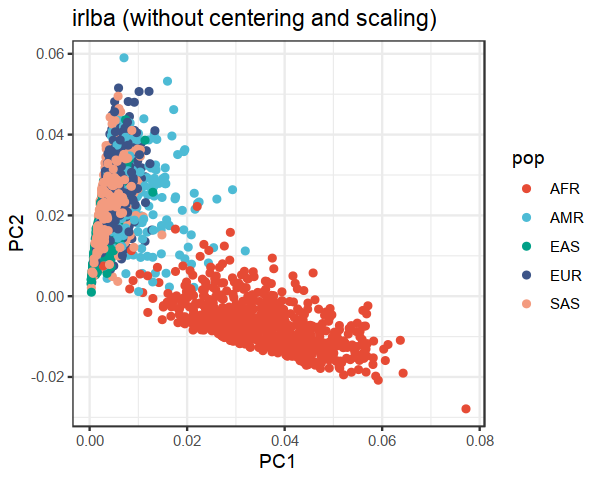

In [185]:
#use the raw scores in U
U <- pca.results$u
toppc <- U[,1:2]
toppc <- - toppc

colnames(toppc) <- c("PC1","PC2")
df <- data.frame(ID=colnames(geno), toppc)
df <- merge(df, popinfo, by="ID")

df %>% ggplot(aes(x=  PC1, y=  PC2, color=pop)) +
    geom_point() +
    theme_bw() +
    scale_color_npg() +
    labs(title="irlba (without centering and scaling)")
    #comment: obviously, substantial change in PC scores happened.

### II-5, PCA with irlba (only centering: without scaling)
- The effect of scaling is substantial in PCA using low-frequency variants!!

In [186]:
pcs.compute <- 2
set.seed(seed = 1)
weight.by.var = TRUE

system.time( pca.results <- irlba(A = t(geno_c), nv = pcs.compute ) )

   user  system elapsed 
 10.768   0.009   0.597 

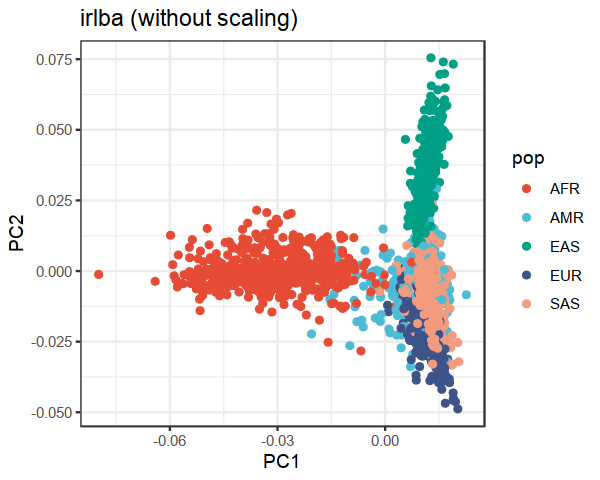

In [187]:
#use the raw scores in U
#almost same plot as PCA using genotype with centering and scaling
U <- pca.results$u
toppc <- U[,1:2]
toppc[,1] <- - toppc[,1]
toppc[,2] <- - toppc[,2]

colnames(toppc) <- c("PC1","PC2")
df <- data.frame(ID=colnames(geno), toppc)
df <- merge(df, popinfo, by="ID")

df %>% ggplot(aes(x=  PC1, y=  PC2, color=pop)) +
    geom_point() +
    theme_bw() +
    scale_color_npg() +
    labs(title="irlba (without scaling)")